In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
from symbol import get_resnet_model
from symbol import YOLO_loss
from data_ulti import get_iterator

In [4]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    return [cxt, cyt, wt, ht]


def bboxdraw(img, label, dscale=32):
    CLASSES = {8:"vehicle", 4:"pedestrian", 2:"cyclist", 1:"traffic lights"}
    assert label.shape == (7,7,9)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.2)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h, cls1, cls2, cls3, cls20 = label[i,j,1:]
        
        cxt, cyt, wt ,ht = decodeBox([i, j, cx,cy,w,h], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        pred = [cls20, cls3, cls2, cls1]
        print(CLASSES)
        print(pred)
        print(CLASSES[2**np.argmax(pred)])
        #print((int(cls1)<<3)+(int(cls2)<<2)+(int(cls3)<<1)+int(cls20))
        
        plt.gca().text(cxt-wt/2,cyt-ht/2,
                    '{:s} {:.3f}'.format(CLASSES[2**np.argmax(pred)], 
                                         pred[np.argmax([cls20, cls3, cls2, cls1])]),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=8, color='white')

    plt.show()

In [150]:
data = mx.io.ImageRecordIter(path_imgrec='val.rec',
                             data_shape=(3,224,224),
                             label_width=7*7*9, 
                             batch_size=1,)

In [151]:
# get sym 
sym, args_params, aux_params = mx.model.load_checkpoint('detect_full_scale', 600)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(data.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=data, num_batch=2000)

In [152]:
out.shape

(2000L, 7L, 7L, 9L)

In [230]:
num=1500
data.reset()
for i in range(num):
    batch = data.next()
img = batch.data[0].asnumpy()[0].transpose((1,2,0))
label = batch.label[0].asnumpy().reshape((7,7,9))
pred = (out.asnumpy()[num-1]+1)/2
print pred.shape

(7, 7, 9)


Prediction
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.014660239, 0.012071669, 0.016648769, 0.046679646]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.011607736, 0.015092075, 0.014375269, 0.11674428]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.022712141, 0.02816847, 0.020403862, 0.93560886]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.019932181, 0.031058252, 0.021401912, 0.92910671]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.021041334, 0.05309993, 0.033862323, 0.96139103]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.020331681, 0.053888112, 0.10126856, 0.019617587]
pedestrian
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.017274499, 0.036838949, 0.041168988, 0.030005217]
pedestrian
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0063747168, 0.0065377951

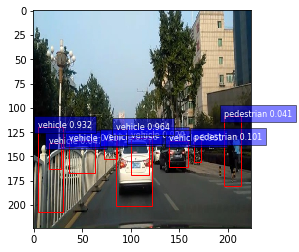

In [231]:
print "Prediction"
bboxdraw(img, pred)

Ground Truth
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 0.0, 0.0, 1.0]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 0.0, 0.0, 1.0]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 0.0, 0.0, 1.0]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 0.0, 0.0, 1.0]
vehicle
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 1.0, 0.0, 0.0]
cyclist
{8: 'vehicle', 1: 'traffic lights', 2: 'cyclist', 4: 'pedestrian'}
[0.0, 0.0, 1.0, 0.0]
pedestrian


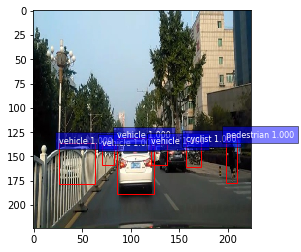

In [232]:
print "Ground Truth"
bboxdraw(img, label)